# Forecasting web traffic
In this project, I develop an autoregressive model to forecast web traffic using historical data. The model, named ForecasterAutoreg, employs a linear regressor with Ridge regularization. This approach leverages a time window of 14 days, meaning that for each prediction, the web traffic data from the previous two weeks is used as predictors.

To ensure the effectiveness of the Ridge regression model, which requires standardized predictors, a StandardScaler is incorporated into the forecasting pipeline. This standardization is achieved by adding the scaler to the forecaster through the transformer_y argument. By doing so, the model benefits from improved stability and performance, providing more accurate predictions of future web traffic trends.

This combination of autoregressive modeling and standardization techniques allows us to create a robust framework for anticipating web traffic patterns, helping to inform decision-making processes and optimize resource allocation.

## Libraries

In [5]:
# Data processing
import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth']=1.5
plt.rcParams['font.size']=10

# Modelling and forecasting
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from pmdarima import ARIMA

# Warnings config
import warnings
warnings.filterwarnings('ignore')

## Data
Data has been obtained from the google analytics service integrated into the website and can be dosnloades in the source bellow. The fields included are:
- date: day/month/year
- users: total number of users who visit the web<br><br>
Source: [dataset](https://github.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/blob/master/data/visitas_por_dia_web_cienciadedatos.csv)

In [6]:
data=pd.read_csv('visitas_por_dia_web_cienciadedatos.csv', sep=',')
data.head(5)

,date,users
0,1/7/20,2324
1,2/7/20,2201
2,3/7/20,2146
3,4/7/20,1666
4,5/7/20,1433


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    421 non-null    object
 1   users   421 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 6.7+ KB


Column date is stored as object. It is converted to datetime type using pd.to_datetime() function. Furthermore, it is set as an index to take advantage of pandas functionalities and finally, its frequency is set to 1 day.<br><br>
### Data Preprocessing

In [8]:
data['date']=pd.to_datetime(data['date'], format='%d/%m/%y')
data=data.set_index('date')
data=data.asfreq('1D')
data=data.sort_index()
data.head(5)

,users
date,
2020-07-01,2324
2020-07-02,2201
2020-07-03,2146
2020-07-04,1666
2020-07-05,1433


In [9]:
# Check index is complete or there are missing values
(data.index==pd.date_range(
    start=data.index.min(),
    end=data.index.max(),
    freq=data.index.freq
)).all()

True

In [10]:
print(f"Missing values: {data.isnull().any(axis=1).sum()}")

Missing values: 0


The dataet (starts on 2020-07-01 and ends on 2021-08-22), is divided into 3 partitions: one for training, one for validation and one for testing.

In [11]:
# Split data: train-validation-test

end_train='2021-03-30 23:59:00'
end_validation='2021-06-30 23:59:00'

data_train=data.loc[:end_train, :]
data_val=data.loc[end_train:end_validation, :]
data_test=data.loc[end_validation:, :]

print(f"Training dates     : {data_train.index.min()} --- {data_train.index.max()} (n={len(data_train)})")
print(f"Validation dates   : {data_val.index.min()} --- {data_val.index.max()} (n={len(data_val)})")
print(f"Test dates         : {data_test.index.min()} --- {data_test.index.max()} (n={len(data_test)})")

Training dates     : 2020-07-01 00:00:00 --- 2021-03-30 00:00:00 (n=273)
Validation dates   : 2021-03-31 00:00:00 --- 2021-06-30 00:00:00 (n=92)
Test dates         : 2021-07-01 00:00:00 --- 2021-08-25 00:00:00 (n=56)


## Graphical exploration
When working wit time series, it is important to represent their values. This allows patterns such as trends and seasonality to be identified.
### Time series
#### Static plot
This code creates a static plot using Matplotlib to visualize daily web traffic data from three different datasets: training, validation, and testing.

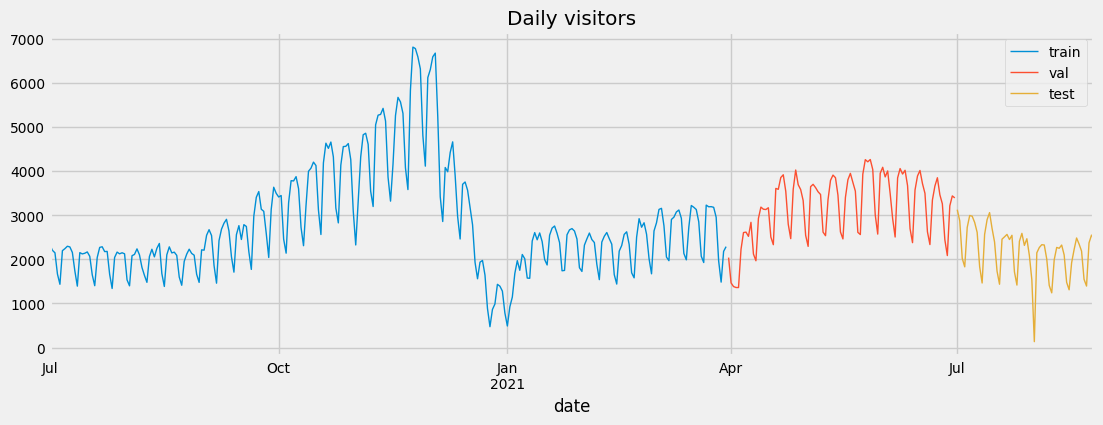

In [12]:
fig, ax = plt.subplots(figsize=(12, 4))
data_train.users.plot(ax=ax, label='train', linewidth=1)
data_val.users.plot(ax=ax, label='val', linewidth=1)
data_test.users.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Daily visitors')
ax.legend()

In [13]:
# Interactive plot
plot_train=data_train.users.hvplot.line(label='train')
plot_val=data_val.users.hvplot.line(label='val')
plot_test=data_test.users.hvplot.line(label='test')

layout=plot_train*plot_val*plot_test
layout=layout.opts(title='Daily visitors', ylabel='users')
layout=layout.opts(height=300, width=550)
layout

:Overlay
   .Curve.Train :Curve   [date]   (users)
   .Curve.Val   :Curve   [date]   (users)
   .Curve.Test  :Curve   [date]   (users)

### Seasonality
This code creates a static plot to visualize the distribution of web traffic data (number of users) on a monthly basis.<br><br>
The result is a combined box plot and line plot that shows both the distribution of daily visitors for each month and the median number of visitors, providing a clear visual summary of the monthly web traffic trends.

Text(0.5, 0.98, '')

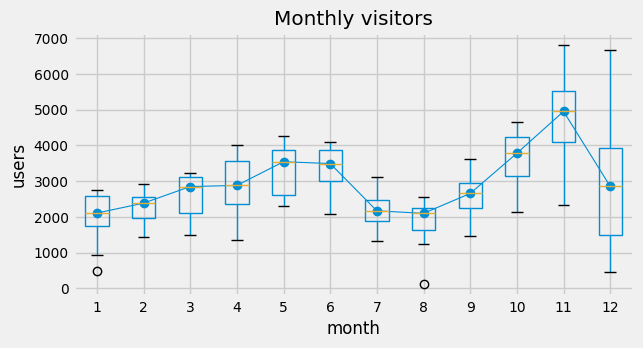

In [14]:
# Static plot

fig, ax=plt.subplots(figsize=(7, 3.5))
data['month']=data.index.month
data.boxplot(column='users', by='month', ax=ax)
data.groupby('month')['users'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('users')
ax.set_title('Monthly visitors')
fig.suptitle('')

In [15]:
# Interactive plot
data['month']=data.index.month
boxplot=data.sort_values('month').hvplot.box(
    y='users',
    by='month',
    legend=False,
    box_fill_color=None,
    outlier_fill_color=None
)

lineplot=data.groupby('month')['users'].median().hvplot.line(legend=False)
scatterplot=data.groupby('month')['users'].median().hvplot.scatter(legend=False)
layout=boxplot * lineplot * scatterplot
layout=layout.opts(title='Monthly visitors', ylabel='users')
layout=layout.opts(height=300, width=500)
layout

:Overlay
   .BoxWhisker.I  :BoxWhisker   [month]   (users)
   .Curve.Users   :Curve   [month]   (users)
   .Scatter.Users :Scatter   [month]   (users)

This code creates a static plot to visualize the distribution of web traffic data (number of users) for each day of the month.<br><br>
The result is a combined box plot and line plot that shows both the distribution of daily visitors for each day of the month and the median number of visitors, providing a clear visual summary of daily web traffic trends throughout the month.

Text(0.5, 0.98, '')

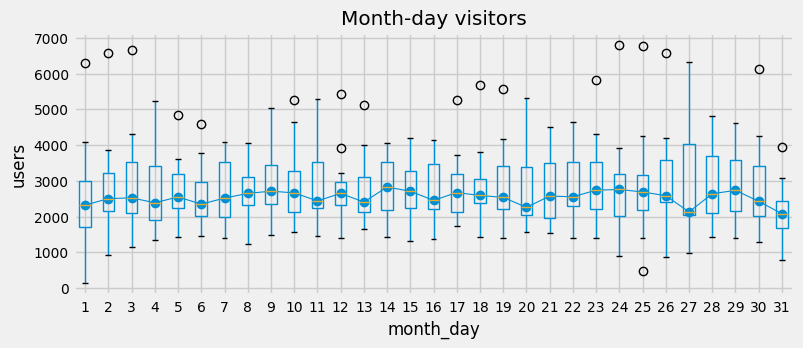

In [47]:
# Static plot

fig, ax=plt.subplots(figsize=(9, 3.5))
data['month_day']=pd.Series(data.index).dt.day.values
data.boxplot(column='users', by='month_day', ax=ax)
data.groupby('month_day')['users'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('users')
ax.set_title('Month-day visitors')
fig.suptitle('')

In [16]:
# Interactive plot

data['month_day']=pd.Series(data.index).dt.day.values
boxplot=data.hvplot.box(
    y='users',
    by='month_day',
    legend=False,
    box_fill_color=None,
    outlier_fill_color=None
)

lineplot=data.groupby('month_day')['users'].median().hvplot.line(legend=False)
scatterplot=data.groupby('month_day')['users'].median().hvplot.scatter(legend=False)
layout=boxplot*lineplot*scatterplot
layout=layout.opts(title='Month-day visitors', ylabel='users')
layout=layout.opts(height=300, width=500)
layout

:Overlay
   .BoxWhisker.I  :BoxWhisker   [month_day]   (users)
   .Curve.Users   :Curve   [month_day]   (users)
   .Scatter.Users :Scatter   [month_day]   (users)

This code creates a static plot to visualize the distribution of web traffic data (number of users) for each day of the week.<br><br>
The result is a combined box plot and line plot that shows both the distribution of daily visitors for each day of the week and the median number of visitors, providing a clear visual summary of weekly web traffic trends.

Text(0.5, 0.98, '')

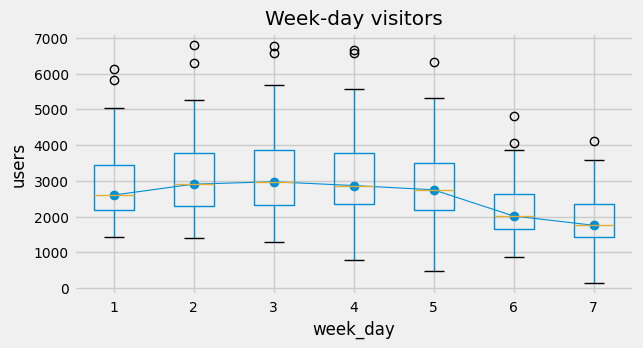

In [49]:
# Static plot

fig, ax=plt.subplots(figsize=(7, 3.5))
data['week_day']=data.index.day_of_week+1
data.boxplot(column='users', by='week_day', ax=ax)
data.groupby('week_day')['users'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('users')
ax.set_title('Week-day visitors')
fig.suptitle('')

In [17]:
# Interactive plot

data['week_day']=data.index.day_of_week+1
boxplot=data.sort_values('week_day').hvplot.box(
    y='users',
    by='week_day',
    legend=False,
    box_fill_color=None,
    outlier_fill_color=None
)
lineplot=data.groupby('week_day')['users'].median().hvplot.line(legend=False)
scatterplot=data.groupby('week_day')['users'].median().hvplot.scatter(legend=False)
layout=boxplot*lineplot*scatterplot
layout=layout.opts(title='Week day visitors', ylabel='users')
layout=layout.opts(height=300, width=500)
layout

:Overlay
   .BoxWhisker.I  :BoxWhisker   [week_day]   (users)
   .Curve.Users   :Curve   [week_day]   (users)
   .Scatter.Users :Scatter   [week_day]   (users)

It cannot be determined if there is an annual seasonality since the data does not span two years. However, there is a weekly seasonality, with reduction in web traffic on weekends

### Autocorrelation plots
It shows how the values of the time series relate to their past values as the lag increases.

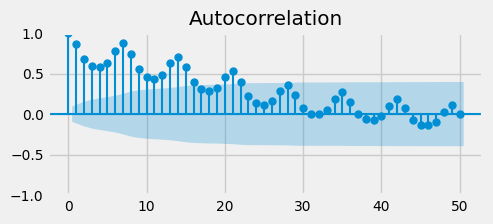

In [51]:
# Autocorrelation plot

fig, ax=plt.subplots(figsize=(5, 2))
plot_acf(data.users, ax=ax, lags=50)
plt.show()

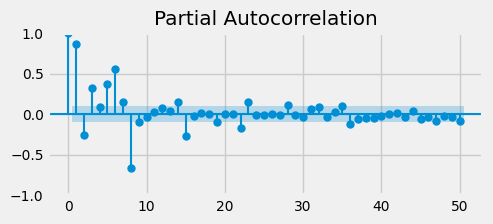

In [52]:
# Partial autocorrelation plot
fig, ax=plt.subplots(figsize=(5, 2))
plot_pacf(data.users, ax=ax, lags=50)
plt.show()

Autocorrelation and partial autocorrelation plots show a clear association between the number of users on a day and the previous days. This is an indication that autoregressive models may achive good predictions.

## Autoregressive model
A autoregressive model (<span style='color:red'>ForecasterAutoreg</span>) is trained using a linear regressor with Ridge regularization, and a time window of 2 weeks (14 lags). The latter means that, for each prediction, the treffic the website had in the previous 14 days is used as predictors.<br><br>
Ridge models require predictors to be standardized. A <span style='color:red'>StandardScaler</span> is added to the forecaster using the argument <span style='color:red'>transformer_y</span>

### Training Forecaster

In [53]:
# Create and train forecaster

forecaster=ForecasterAutoreg(
    regressor=Ridge(random_state=42),
    lags=14,
    transformer_y=StandardScaler(),
    forecaster_id='web_traffic'
)

forecaster.fit(y=data_train.users)
forecaster

ForecasterAutoreg 
Regressor: Ridge(random_state=42) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 14 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2020-07-01 00:00:00'), Timestamp('2021-03-30 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 42, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2024-02-27 12:19:03 
Last fit date: 2024-02-27 12:19:03 
Skforecast version: 0.11.0 
Python version: 3.9.10 
Forecaster id: web_traffic 

### Prediction (backtest)
In order to evaluate the model, it is trained using data from 2020-07-01 to 2021-06-30 and then, predictions are made seven days at a time, without retraining the model. This type of validation is known as backtesting, and can be easily applied with the function <span style='color:red'>backtesting_forecaster()</span>

In [54]:
# Backtest

metric, predictions=backtesting_forecaster(
    forecaster=forecaster,
    y=data.users,
    initial_train_size=len(data.loc[:end_validation]),
    steps=7,
    refit=False,
    fixed_train_size=False,
    metric='mean_absolute_error',
    verbose=True,
    show_progress=False
)

print(f"Backtest error: {np.round(metric, 3)}")

predictions.head(5)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 365
Number of observations used for backtesting: 56
    Number of folds: 8
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-01 00:00:00 -- 2021-07-07 00:00:00  (n=7)
Fold: 1
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-08 00:00:00 -- 2021-07-14 00:00:00  (n=7)
Fold: 2
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-15 00:00:00 -- 2021-07-21 00:00:00  (n=7)
Fold: 3
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-22 00:00:00 -- 2021-07-28 00:00:00  (n=7)
Fold: 4
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-29 00:00:00 -- 2021-0

,pred
2021-07-01,3199.921107
2021-07-02,2998.675773
2021-07-03,2256.899442
2021-07-04,2038.767690
2021-07-05,2998.858487


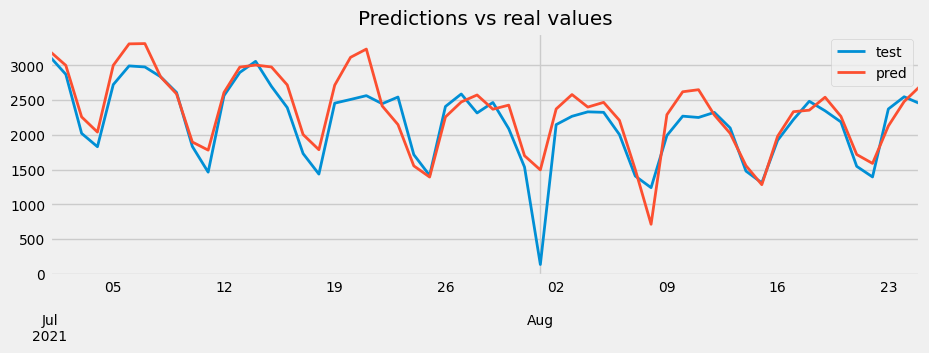

In [55]:
# Static Plot

fig, ax=plt.subplots(figsize=(10, 3))
data_test.loc[predictions.index, 'users'].plot(ax=ax, linewidth=2, label='test')
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Predictions vs real values')
ax.legend()

In [56]:
# Interactive plot

plot_test=data_test.users.hvplot.line(label='test')
plot_predict=predictions.hvplot.line(label='prediction')
layout=plot_test*plot_predict
layout=layout.opts(
    title='Predictions vs real values',
    ylabel='users',
    legend_position='bottom_left'
)
layout=layout.opts(height=300, width=550)
layout

:Overlay
   .Curve.Test       :Curve   [date]   (users)
   .Curve.Prediction :Curve   [index]   (pred)

### Turing the hyper-parameters
In the previous section, the first 14 lags have been used as predictors and a [Ridge](https://cienciadedatos.net/documentos/py14-ridge-lasso-elastic-net-python) mmodel with the default hyperparameters as regressor. However, there is no reason why these values should be the most appropriate.<br><br>
In order to identify the best combination of lags and hyperparameters, a grid search is used. This process consists of training a model with each combination of hyperparameters-lags, and evaluating its predictive capacity using backtesting. It is important to evaluate the models using only the validation data nad not include the test data.

In [57]:
# Grid search of hyper-parameters

forecaster=ForecasterAutoreg(
    regressor=Ridge(random_state=42),
    lags=14,
    transformer_y=StandardScaler(),
    forecaster_id='web_traffic'
)

# Regresor's hyper-parameters
param_grid={'alpha':np.logspace(-3, 3, 10)}

# Lags used as predictors
lags_grid=[7, 14, 21, [7, 14, 21]]

grid_results=grid_search_forecaster(
    forecaster=forecaster,
    y=data.loc[:end_validation, 'users'],
    param_grid=param_grid,
    lags_grid=lags_grid,
    steps=7,
    metric='mean_absolute_error',
    refit=False,
    initial_train_size=len(data_train),
    fixed_train_size=False,
    return_best=True,
    show_progress=True,
    verbose=False
)

Number of models compared: 40.


lags grid: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'alpha': 2.154434690031882}
  Backtesting metric: 214.79167668434485



In [58]:
# Grid search results
grid_results.head(10)

,lags,params,mean_absolute_error,alpha
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 2.154434690031882},214.791677,2.154435
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 0.46415888336127775},216.551409,0.464159
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 0.1},217.770757,0.100000
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 0.021544346900318832},218.127429,0.021544
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 0.004641588833612777},218.206475,0.004642
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 0.001},218.223609,0.001000
26,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 10.0},219.315042,10.000000
16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 10.0},220.932702,10.000000
25,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 2.154434690031882},221.500069,2.154435
24,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.46415888336127775},226.720683,0.464159


The best results are obtained using lags [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] and a configuration of Ridge {'alpha': 2.154}. By indicating <span style='color:red'>return_best=True</span> in the <span style='color:red'>grid_search_forecaster</span> function, at the end of the process, the forecaster object is automatically retrained with the best configuration and the whole data set.

In [59]:
forecaster

ForecasterAutoreg 
Regressor: Ridge(alpha=2.154434690031882, random_state=42) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 14 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2020-07-01 00:00:00'), Timestamp('2021-06-30 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'alpha': 2.154434690031882, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 42, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2024-02-27 12:19:04 
Last fit date: 2024-02-27 12:19:07 
Skforecast version: 0.11.0 
Python version: 3.9.10 
Forecaster id: web_traffic 

Once the best model has been identified and trained (using both, the training and the validation set), its prediction error is calculated with the test set.

In [60]:
# Backtest final model using test data

metric, predictions=backtesting_forecaster(
    forecaster=forecaster,
    y=data.users,
    initial_train_size=len(data.loc[:end_validation, :]),
    steps=7,
    refit=False,
    fixed_train_size=False,
    metric='mean_absolute_error',
    show_progress=True,
    verbose=False
)

print(f"Backtest error using test data: {np.round(metric, 3)}")

100%|██████████| 8/8 [00:00<00:00, 201.69it/s]

Backtest error using test data: 216.356


After optimizing lags and hyperparameters, it has been possible to reduce the prediction error.

## ARIMA model
SARIMAX (Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors) is a generalization of the ARIMA model that incorporates both seasonality and exogenous varables. SARIMAX models are among the most widely used statistical forecasting models with excellent forecasting performance.<br><br>
Skforcast uses the [pmdarima](https://github.com/alkaline-ml/pmdarima) of the [ARIMA](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ARIMA.html) model in conjuctionwith the <span style='color:red'>ForecasterSarimax</span> class. Validation and optimization can be performed using the <span style='color:red'>backtesting_sarimax</span> and <span style='color:red'>grid_search_sarimax</span> functions of the <span style='color:red'>model_selection_sarimax</span> module.

In [61]:
# ForecasterSarimax

forecaster_sarimax=ForecasterSarimax(
    regressor=ARIMA(order=(14, 0, 0), maxiter=250),
    fit_kwargs={'disp':0},
    forecaster_id='web_traffic_sarimax'
)

# Backtest ARIMA
metric, predictions = backtesting_sarimax(
    forecaster=forecaster_sarimax,
    y=data.users,
    initial_train_size=len(data.loc[:end_validation]),
    steps=7,
    metric='mean_absolute_error',
    refit=False,
    fixed_train_size=False,
    verbose=False,
    show_progress=True
)

print(f"Backtest error: {metric}")
predictions.head(5)

100%|██████████| 8/8 [00:00<00:00, 32.31it/s]

Backtest error: 221.16173708458794


,pred
2021-07-01,3168.884240
2021-07-02,2982.103710
2021-07-03,2241.585792
2021-07-04,2007.877674
2021-07-05,2986.983831


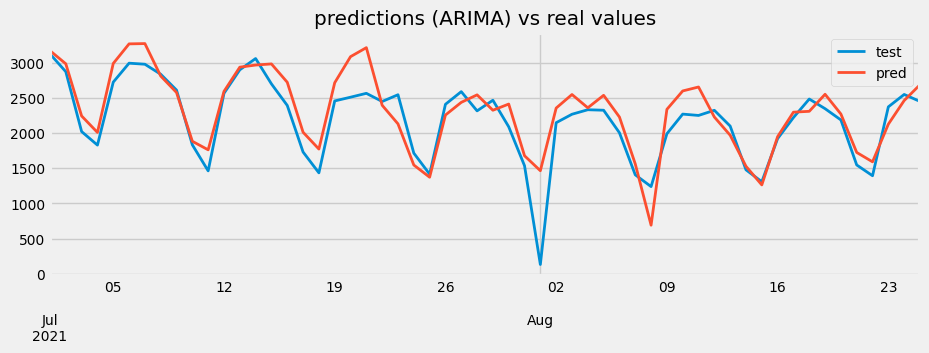

In [62]:
# Static Plot

fig, ax=plt.subplots(figsize=(10, 3))
data_test.loc[predictions.index, 'users'].plot(linewidth=2, label='test', ax=ax)
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('predictions (ARIMA) vs real values')
ax.legend()

In [63]:
# Interactive plot

plot_test=data_test.users.hvplot.line(label='test')
plot_predict=predictions['pred'].hvplot.line(label='prediction')
layout=plot_test*plot_predict
layout=layout.opts(
    title='Predictions (ARIMA) vs real values',
    ylabel='users',
    legend_position='bottom_left'
)
layout=layout.opts(height=300, width=550)
layout

:Overlay
   .Curve.Test       :Curve   [date]   (users)
   .Curve.Prediction :Curve   [index]   (pred)

### Tuning the hyperparameters
Like most models, ARIMA has several hyperparameters that control its behaivor:<br><br>
- _p_ is the order (number of time lags) of the autorregressive part of the model.
- _d_ is the degree of differencing (the number of times that past values have been subtracted from the data).
- _q_ is the order of the moving-average part of the model.<br><br>
In the pmdarime implementation, these hyperparameters are specified by the <span style='color:red'>order</span> argument. Two good references for mre details on ARIMA models are: https://openforecast.org/adam/ARIMA.html and https://otexts.com/fpp3/arima.html.<br><br>
The <span style='color:red'>grid_search_sarimax</span> function can be used to perform a hyperparameter search by comparing the models according to a metric obtained by backtesting. [Check other tuning strategies](https://skforecast.org/0.11.0/api/model_selection_sarimax.html)

In [64]:
# Grid search of hyperparameters
param_grid={'order':[(14, 0, 0), (14, 2, 0), (14, 1, 0), 
                     (14, 1, 1), (14, 1, 4), (21, 0, 0), 
                     (21, 0, 0), (21, 1, 0), (21, 1, 1), 
                     (21, 1, 4)]}

results=grid_search_sarimax(
    forecaster=forecaster_sarimax,
    y=data.users,
    param_grid=param_grid,
    initial_train_size=len(data.loc[:end_validation]),
    steps=7,
    metric='mean_absolute_error',
    refit=False,
    fixed_train_size=False,
    return_best=True,
    verbose=False
)

results

Number of models compared: 10.


params grid: 100%|██████████| 10/10 [03:22<00:00, 20.24s/it]


`Forecaster` refitted using the best-found parameters, and the whole data set: 
  Parameters: {'order': (21, 1, 1)}
  Backtesting metric: 181.83602267522673



,params,mean_absolute_error,order
8,"{'order': (21, 1, 1)}",181.836023,"(21, 1, 1)"
7,"{'order': (21, 1, 0)}",183.123524,"(21, 1, 0)"
3,"{'order': (14, 1, 1)}",194.962497,"(14, 1, 1)"
2,"{'order': (14, 1, 0)}",195.237328,"(14, 1, 0)"
5,"{'order': (21, 0, 0)}",201.172395,"(21, 0, 0)"
6,"{'order': (21, 0, 0)}",201.172395,"(21, 0, 0)"
1,"{'order': (14, 2, 0)}",201.630901,"(14, 2, 0)"
9,"{'order': (21, 1, 4)}",211.592536,"(21, 1, 4)"
0,"{'order': (14, 0, 0)}",221.161737,"(14, 0, 0)"
4,"{'order': (14, 1, 4)}",226.769230,"(14, 1, 4)"


In [65]:
# Backtest final model using test data

metric, predictions=backtesting_sarimax(
    forecaster=forecaster_sarimax,
    y=data.users,
    initial_train_size=len(data.loc[:end_validation]),
    steps=7,
    metric='mean_absolute_error',
    refit=False,
    fixed_train_size=False,
    verbose=False,
    show_progress=True
)

print(f"Backtest error: {metric}")

100%|██████████| 8/8 [00:00<00:00, 25.61it/s]

Backtest error: 181.83602267522673


## Forecasting adding exogenous features
In the prvious example, only lags of the target variable itself were used as predictors. In certain situations, it is possible to have information on other variabels __whose future value is known__, which can be used as additional predictors in the model. Some typical examples are:<br><br>
- Holidays (local, national...)
- Month of the year
- Day of the week
- Time of day<br><br>

In this use case, the graphical analysis showed evidence that the number of visits to the website decreases at weekends. The day of the week that each data corresponds to can be known in advance, so it can be used as an exogenous variable. See how it affects the models when this information is included as a predictor.

In [66]:
# Creation of new exogenous features
data=data.drop(columns=['month', 'month_day'])

# One hot encoding of week day
data=pd.get_dummies(data, columns=['week_day'], dtype='int64')
data.head(5)

,users,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5,week_day_6,week_day_7
date,,,,,,,,
2020-07-01,2324,0,0,1,0,0,0,0
2020-07-02,2201,0,0,0,1,0,0,0
2020-07-03,2146,0,0,0,0,1,0,0
2020-07-04,1666,0,0,0,0,0,1,0
2020-07-05,1433,0,0,0,0,0,0,1


In [67]:
# Split data train-val-test

data_train=data.loc[:end_train, :]
data_val=data.loc[end_train:end_validation, :]
data_test=data.loc[end_validation:, :]

### ForecasterAutoreg

In [69]:
# Create and train forecaster

forecaster=ForecasterAutoreg(
    regressor=Ridge(alpha=2.15, random_state=1),
    lags=14,
    transformer_y=StandardScaler(),
    forecaster_id='web_traffic'
)

col_exog=[column for column in data.columns if column.startswith(('week'))]
forecaster.fit(y=data_train.users, exog=data_train[col_exog])

In [70]:
# Backtest forecaster with exogenous features

metric, predictions=backtesting_forecaster(
    forecaster=forecaster,
    y=data.users,exog=data[col_exog],
    initial_train_size=len(data.loc[:end_validation, :]),
    steps=7,
    metric='mean_absolute_error',
    refit=False,
    fixed_train_size=False,
    verbose=False,
    show_progress=True
)

print(f"BAcktest error: {np.round(metric, 4)}")
predictions.head(5)

100%|██████████| 8/8 [00:00<00:00, 177.52it/s]

BAcktest error: 195.8887


,pred
2021-07-01,3286.890749
2021-07-02,3021.079567
2021-07-03,2256.401254
2021-07-04,1985.650262
2021-07-05,3039.877224


### ARIMA

In [71]:
# ForecasterSarimax

forecaster_sarimax=ForecasterSarimax(
    regressor=ARIMA(order=(21, 1, 1),
                    seasonal_order=(0, 0, 0, 0),
                    maxiter=250),
    fit_kwargs={'disp':0},
    forecaster_id='web_traffic_sarimax'
)

In [72]:
# Backtest ARIMA with exogenous features

metric, predictions=backtesting_sarimax(
    forecaster=forecaster_sarimax,
    y=data.users,
    exog=data[col_exog],
    initial_train_size=len(data.loc[:end_validation]),
    steps=7,
    metric='mean_absolute_error',
    refit=False,
    fixed_train_size=False,
    verbose=False,
    show_progress=True
)

print(f"Backtest error: {np.round(metric, 4)}")
predictions.head(5)

100%|██████████| 8/8 [00:00<00:00, 23.98it/s]

Backtest error: 204.1147


,pred
2021-07-01,3283.667028
2021-07-02,3020.004727
2021-07-03,2282.065655
2021-07-04,2013.361439
2021-07-05,3106.195932


## Prediction intervals
Both functions, <span style='color:red'>backtesting_forecaster</span> and <span style='color:red'>backtesting_sarimax</span>, allow obtaining their intervals in addition to the predictions.

In [73]:
# Backtest with prediction intervals

metric, predictions = backtesting_sarimax(
                          forecaster=forecaster_sarimax,
                          y=data.users,
                          exog=data[col_exog],
                          initial_train_size=len(data.loc[:end_validation]),
                          steps=7,
                          metric='mean_absolute_error',
                          refit=False,
                          fixed_train_size=False,
                          alpha=0.05,
                          verbose=False,
                          show_progress=True
                      )

print(f'Backtest error: {np.round(metric, 4)}')
predictions.head(5)

100%|██████████| 8/8 [00:00<00:00, 23.55it/s]

Backtest error: 204.1147


,pred,lower_bound,upper_bound
2021-07-01,3283.667028,2846.841893,3720.492162
2021-07-02,3020.004727,2382.345585,3657.663868
2021-07-03,2282.065655,1551.090395,3013.040915
2021-07-04,2013.361439,1201.309949,2825.412929
2021-07-05,3106.195932,2220.344860,3992.047004


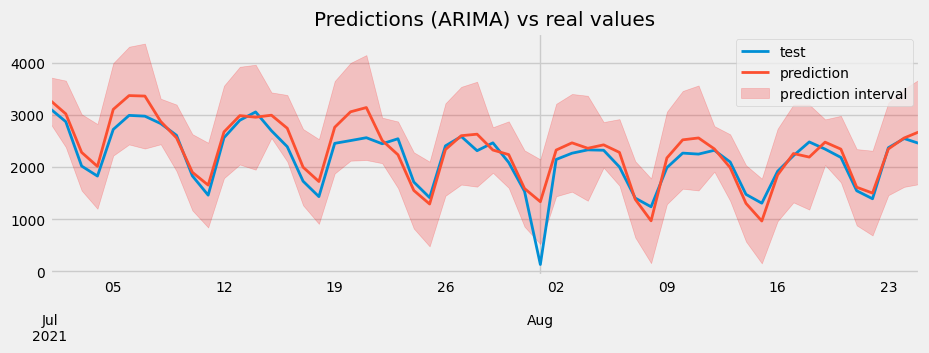

In [74]:
# Static plot

fig, ax=plt.subplots(figsize=(10, 3))
data_test.loc[predictions.index, 'users'].plot(linewidth=2, label='test', ax=ax)
predictions.iloc[:, 0].plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Predictions (ARIMA) vs real values')
ax.fill_between(
    predictions.index,
    predictions.iloc[:, 1],
    predictions.iloc[:, 2],
    alpha=0.2,
    color='red',
    label='prediction interval'
)
ax.legend()

In [75]:
# Interactive plot

plot_test=data_test.users.hvplot.line(label='test')
plot_predict=predictions['pred'].hvplot.line(label='prediction')
plot_intervalo=predictions.hvplot.area(
    y='lower_bound',
    y2='upper_bound',
    color='red',
    alpha=0.2,
    label='prediction interval'
)
layout=plot_intervalo*plot_test*plot_predict
layout=layout.opts(
    title='Predictions (ARIMA) vs real values',
    ylabel='users',
    legend_position='bottom_left'
)
layout=layout.opts(height=300, width=550)
layout

:Overlay
   .Area.Prediction_interval :Area   [index]   (lower_bound,upper_bound)
   .Curve.Test               :Curve   [date]   (users)
   .Curve.Prediction         :Curve   [index]   (pred)

## Conclusion
The best results are obtained with an ARIMA.<br><br>
| Model | Exogenous features | MAE backtest |
| :- | :- | :- |
| ARIMA | True | 181.3 |
| ARIMA | False | 181.8 |
| autoregressive-ridge | True | 195.9 |
| autoregressive-ridge | False | 216.4 |

<br>
How further improve the model:
- Adding as exogenous feature vacation days.
- Using non linear regressors such as random forest or gradient boosting Forecasting time series with gradient boosting: [Skforecast, XGBoost, LightGBM and CatBoost](https://cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost)
- Using a [direct multi-step forecaster](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/direct-multi-step-forecasting.html)


## Session information

In [77]:
import session_info
session_info.show(html=False)

-----
holoviews           1.18.3
hvplot              0.9.2
matplotlib          3.8.0
numpy               1.24.3
pandas              2.1.1
pmdarima            2.0.4
seaborn             0.13.0
session_info        1.0.0
skforecast          0.11.0
sklearn             1.3.1
statsmodels         0.14.1
-----
IPython             8.16.1
jupyter_client      8.4.0
jupyter_core        5.4.0
jupyterlab          4.0.7
notebook            7.0.5
-----
Python 3.9.10 (tags/v3.9.10:f2f3f53, Jan 17 2022, 15:14:21) [MSC v.1929 64 bit (AMD64)]
Windows-10-10.0.22621-SP0
-----
Session information updated at 2024-02-27 16:18
